# Load Configuration Data

In [64]:
import json
import os

# Check if the file exists and load the JSON file into a dictionary
file_path = r'C:\Users\mike\Develop\Projects\Code Notebook\Credentials\locations_conf.json'
if os.path.exists(file_path):
    with open(file_path, 'r') as f:
        locations_data = json.load(f)
    print(locations_data)
else:
    print(f"File not found: {file_path}")

{'Common_Funcs_Dir': '/Users/mike/Develop/Projects/Code Notebook/Common/Functions', 'Credentials_Dir': '/Users/mike/Develop/Projects/Code Notebook/Credentials', 'Rel_Pickes_Dir': '../.pickles', 'Pub_Data_Dir': "'/Users/mike/Data/Public", 'BQ_Service_Key': '/Users/mike/Develop/Conf/GCP Service Keys/mikecancell-development-0bcca41f8486.json'}


# Load the DF by Querying Banking Data

In [65]:
from google.oauth2 import service_account
import pandas_gbq

# Ensure locations_data is defined
if 'locations_data' not in globals():
	# Check if the file exists and load the JSON file into a dictionary
	if os.path.exists(file_path):
		with open(file_path, 'r') as f:
			locations_data = json.load(f)
	else:
		raise FileNotFoundError(f"File not found: {file_path}")

# Resolve the key path from the locations data
key_path = locations_data.get('BQ_Service_Key', 'default_key_path.json')

# Create credentials using the key file
credentials = service_account.Credentials.from_service_account_file(key_path)

# Define your project ID and the SQL query
project_id = 'mikecancell-development'
query = """
SELECT *
FROM `mikecancell-development.Datasets.Banking_Data`
"""

# Read the data from BigQuery into a pandas DataFrame
bank_data = pandas_gbq.read_gbq(query, project_id=project_id, credentials=credentials)

# Display the first few rows of the dataframe
print(bank_data.head())

Downloading: 100%|██████████|
      Attrition_Flag  Age Gender  Dependent_count Education_Level  \
0  Existing Customer   47      M                4     High School   
1  Existing Customer   62      F                1         Unknown   
2  Existing Customer   60      F                0     High School   
3  Existing Customer   65      M                0        Graduate   
4  Existing Customer   38      M                1        Graduate   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $40K - $60K          Blue              42   
1        Married  Less than $40K          Blue              56   
2        Married  Less than $40K          Blue              50   
3         Single     $40K - $60K          Blue              36   
4         Single    $80K - $120K          Blue              25   

   Total_Relationship_Count  ...  is_Attrited   Age_Group  \
0                         6  ...        False  Age: 45-54   
1                         6  ...    

# Analysis

```markdown
# Outline for Analyzing Bank Data: Drivers of Attrition

## 1. Data Overview
- **Objective**: Identify key drivers of customer attrition by comparing attritted vs existing customers.
- **Dataset Summary**:
    - Total rows: 10,127
    - Key columns: `Attrition_Flag`, `Age`, `Gender`, `Dependent_count`, `Education_Level`, `Income_Category`, `Credit_Limit`, `Total_Trans_Amt`, etc.

## 2. Data Cleaning and Preparation
- Check for missing or null values in critical columns.
- Ensure data types are consistent (e.g., numeric columns for analysis).
- Remove or impute missing values if necessary.

## 3. Exploratory Data Analysis (EDA)
### 3.1 Demographic Analysis
- Compare `Age`, `Gender`, `Education_Level`, and `Marital_Status` distributions between attritted and existing customers.
- Group `Age` into bins (e.g., 18-25, 26-35, etc.) for better visualization.

### 3.2 Financial Behavior
- Analyze `Income_Category`, `Credit_Limit`, and `Avg_Utilization_Ratio` for both groups.
- Identify trends in spending behavior using `Total_Trans_Amt` and `Total_Trans_Ct`.

### 3.3 Account Activity
- Compare `Months_on_book`, `Total_Relationship_Count`, and `Months_Inactive_12_mon`.
- Analyze `Contacts_Count_12_mon` to understand engagement levels.

## 4. Feature Engineering
- Create new features such as:
    - `Credit_Utilization` = `Total_Revolving_Bal` / `Credit_Limit`
    - `Engagement_Score` = `Total_Trans_Ct` / `Months_on_book`
- Group categorical variables into meaningful bins (e.g., `Income_Category`, `Credit_Limit_Group`).

## 5. Statistical Analysis
- Perform hypothesis testing (e.g., t-tests, chi-square tests) to identify significant differences between attritted and existing customers.
- Correlation analysis to find relationships between features and attrition.

## 6. Predictive Modeling
- Build a classification model to predict attrition:
    - Split data into training and testing sets.
    - Use models like Logistic Regression, Random Forest, or Gradient Boosting.
    - Evaluate model performance using metrics like accuracy, precision, recall, and F1-score.

## 7. Insights and Recommendations
- Summarize key findings from the analysis.
- Provide actionable recommendations to reduce attrition, such as:
    - Targeted engagement strategies for high-risk customers.
    - Incentives for customers with low transaction activity.
    - Personalized offers based on financial behavior.

## 8. Visualization
- Use visualizations to support findings:
    - Bar charts for categorical comparisons.
    - Box plots for numerical distributions.
    - Heatmaps for correlation analysis.

## 9. Conclusion
- Recap the main drivers of attrition.
- Highlight next steps for further analysis or business actions.
```

## 1. Data Overview
- **Objective**: Identify key drivers of customer attrition by comparing attritted vs existing customers.
- **Dataset Summary**:
    - Total rows: 10,127
    - Key columns: `Attrition_Flag`, `Age`, `Gender`, `Dependent_count`, `Education_Level`, `Income_Category`, `Credit_Limit`, `Total_Trans_Amt`, etc.

Age: t-statistic = 1.90, p-value = 0.0577
Dependent_count: t-statistic = 1.94, p-value = 0.0525
Credit_Limit: t-statistic = -2.40, p-value = 0.0164
Total_Trans_Amt: t-statistic = -22.69, p-value = 0.0000
Total_Trans_Ct: t-statistic = -54.14, p-value = 0.0000
Avg_Utilization_Ratio: t-statistic = -18.62, p-value = 0.0000
Gender: chi2 = 13.87, p-value = 0.0002
Education_Level: chi2 = 12.51, p-value = 0.0515
Marital_Status: chi2 = 6.06, p-value = 0.1089
Income_Category: chi2 = 12.83, p-value = 0.0250


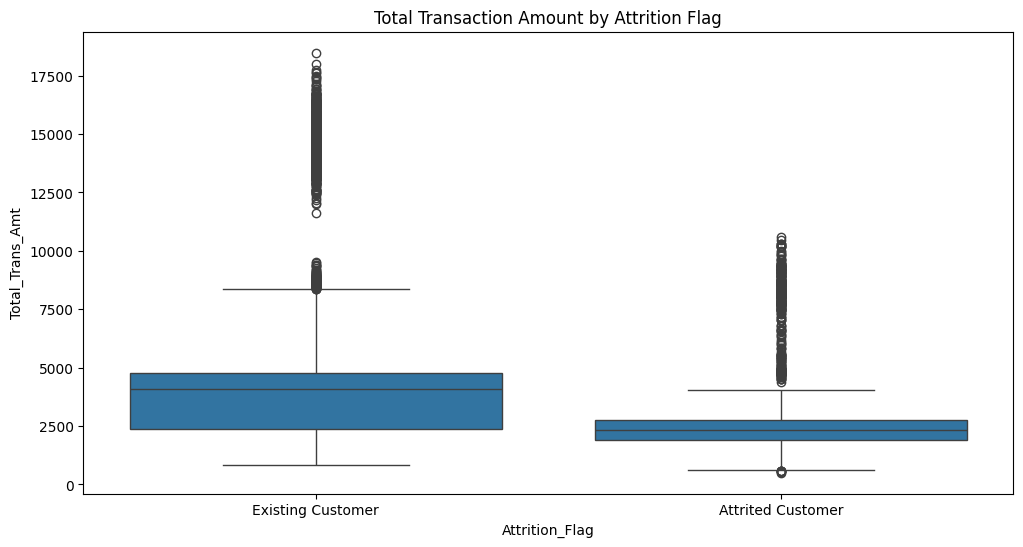

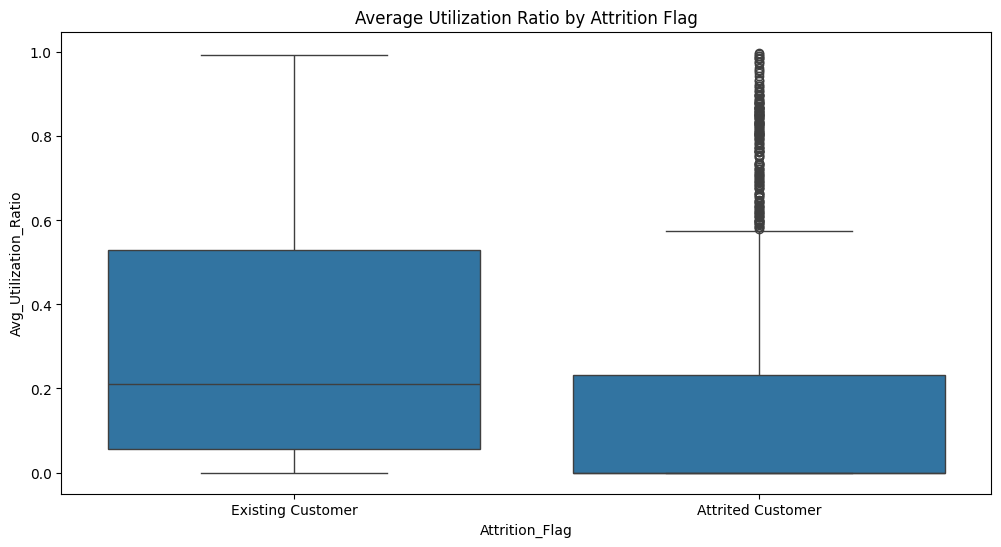

In [66]:
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

import matplotlib.pyplot as plt

# Separate attrited and non-attrited clients
attrited = bank_data[bank_data['Attrition_Flag'] == 'Attrited Customer']
non_attrited = bank_data[bank_data['Attrition_Flag'] == 'Existing Customer']

# Numerical features to analyze
numerical_features = ['Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio']

# Perform t-tests for numerical features
for feature in numerical_features:
    t_stat, p_val = ttest_ind(attrited[feature], non_attrited[feature], equal_var=False)
    print(f"{feature}: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")

# Categorical features to analyze
categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category']

# Perform chi-square tests for categorical features
for feature in categorical_features:
    contingency_table = pd.crosstab(bank_data[feature], bank_data['Attrition_Flag'])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"{feature}: chi2 = {chi2:.2f}, p-value = {p_val:.4f}")

# Visualize key differences
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Total_Trans_Amt', data=bank_data)
plt.title('Total Transaction Amount by Attrition Flag')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Avg_Utilization_Ratio', data=bank_data)
plt.title('Average Utilization Ratio by Attrition Flag')
plt.show()

## 2. Data Cleaning and Preparation
- Check for missing or null values in critical columns.
- Ensure data types are consistent (e.g., numeric columns for analysis).
- Remove or impute missing values if necessary.

In [67]:
# Define critical columns for analysis
critical_columns = ['Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio', 
                    'Gender', 'Education_Level', 'Marital_Status', 'Income_Category']

# Handle missing values (if any)
# For demonstration, we will fill numeric columns with their mean and categorical columns with 'Unknown'
for col in critical_columns:
    if bank_data[col].dtype in ['float64', 'int64', 'Int64']:
        bank_data[col] = bank_data[col].fillna(bank_data[col].mean())
    elif bank_data[col].dtype == 'object':
        bank_data[col] = bank_data[col].fillna('Unknown')

# Verify that there are no missing values after imputation
print("\nMissing values after handling:")
print(bank_data[critical_columns].isnull().sum())



Missing values after handling:
Age                      0
Dependent_count          0
Credit_Limit             0
Total_Trans_Amt          0
Total_Trans_Ct           0
Avg_Utilization_Ratio    0
Gender                   0
Education_Level          0
Marital_Status           0
Income_Category          0
dtype: int64


## 3. Exploratory Data Analysis (EDA)

### 3.1 Demographic Analysis
- Compare `Age`, `Gender`, `Education_Level`, and `Marital_Status` distributions between attritted and existing customers.
- Group `Age` into bins (e.g., 18-25, 26-35, etc.) for better visualization.

#### Group Age into bins & Plot Age distribution by Attrition Flag

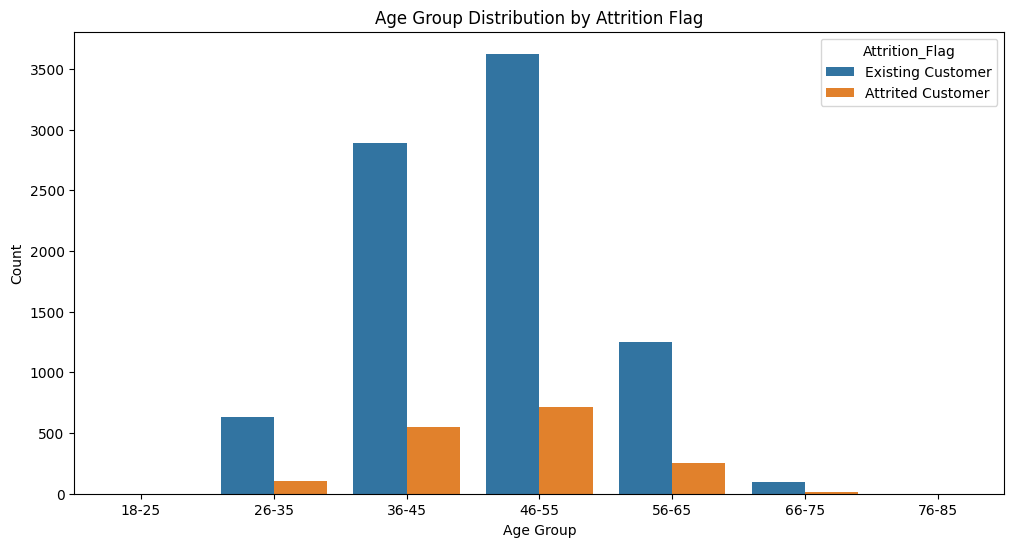

In [68]:
# Group Age into bins
age_bins = [18, 25, 35, 45, 55, 65, 75, 85]
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85']
bank_data['Age_Group'] = pd.cut(bank_data['Age'], bins=age_bins, labels=age_labels, right=False)

# Plot Age distribution by Attrition Flag
plt.figure(figsize=(12, 6))
sns.countplot(x='Age_Group', hue='Attrition_Flag', data=bank_data, order=age_labels)
plt.title('Age Group Distribution by Attrition Flag')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

#### Plot Gender distribution by Attrition Flag

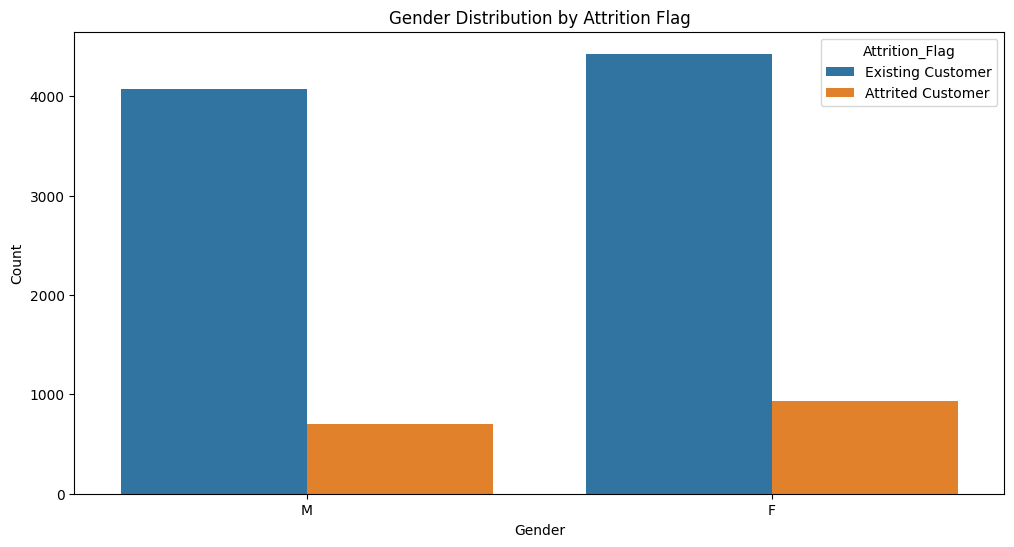

In [69]:
# Plot Gender distribution by Attrition Flag
plt.figure(figsize=(12, 6))
sns.countplot(x='Gender', hue='Attrition_Flag', data=bank_data)
plt.title('Gender Distribution by Attrition Flag')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

#### Plot Education_Level distribution by Attrition Flag

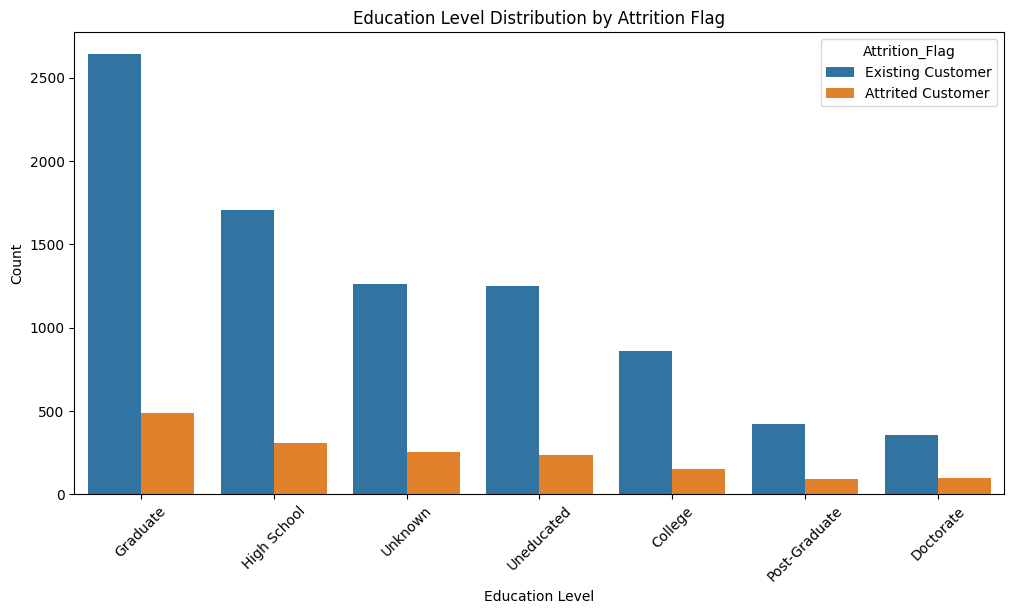

In [70]:
# Plot Education_Level distribution by Attrition Flag
plt.figure(figsize=(12, 6))
sns.countplot(x='Education_Level', hue='Attrition_Flag', data=bank_data, order=bank_data['Education_Level'].value_counts().index)
plt.title('Education Level Distribution by Attrition Flag')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Plot Marital_Status distribution by Attrition Flag

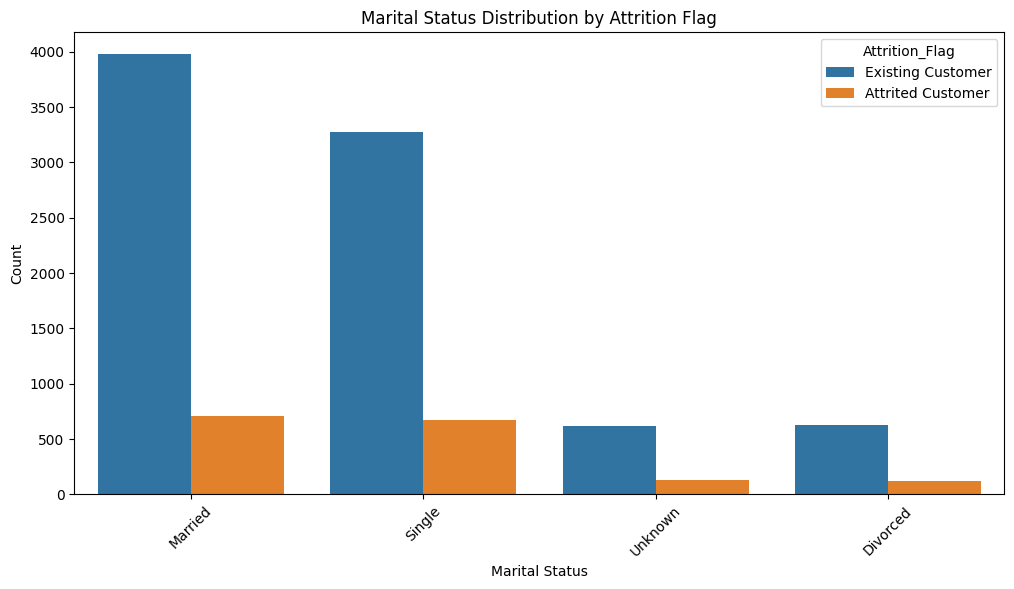

In [71]:
# Plot Marital_Status distribution by Attrition Flag
plt.figure(figsize=(12, 6))
sns.countplot(x='Marital_Status', hue='Attrition_Flag', data=bank_data, order=bank_data['Marital_Status'].value_counts().index)
plt.title('Marital Status Distribution by Attrition Flag')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 3.2 Financial Behavior
- Analyze `Income_Category`, `Credit_Limit`, and `Avg_Utilization_Ratio` for both groups.
- Identify trends in spending behavior using `Total_Trans_Amt` and `Total_Trans_Ct`.

#### # Analyze Income_Category distribution

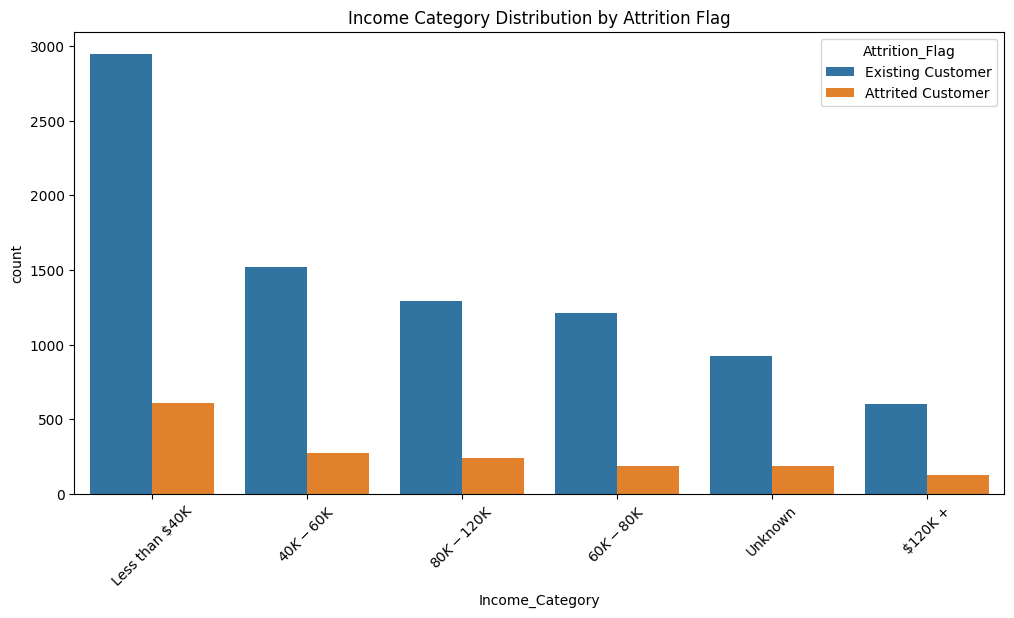

In [72]:
# Analyze Income_Category distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Income_Category', hue='Attrition_Flag', data=bank_data, order=bank_data['Income_Category'].value_counts().index)
plt.title('Income Category Distribution by Attrition Flag')
plt.xticks(rotation=45)
plt.show()


#### Analyze Credit_Limit distribution

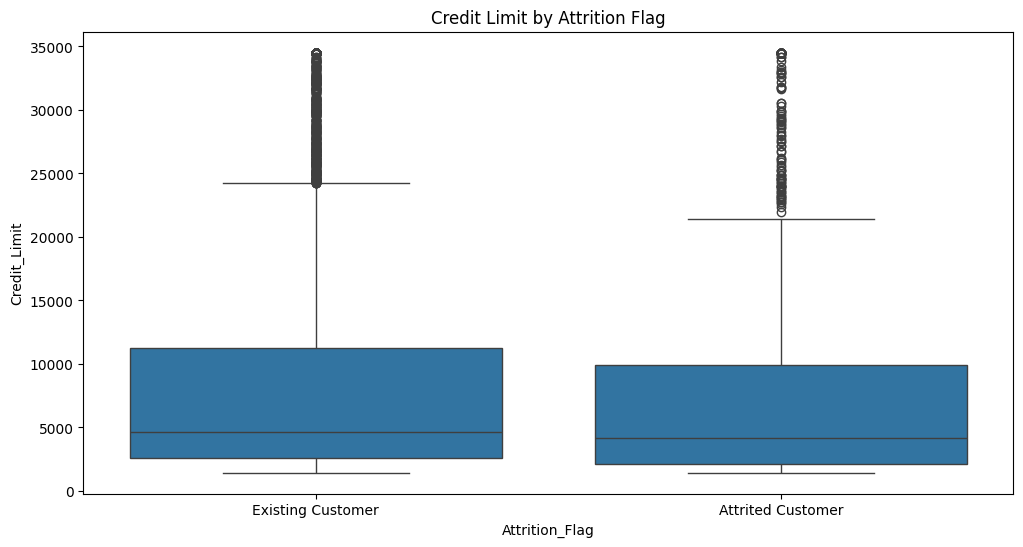

In [73]:
# Analyze Credit_Limit distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Credit_Limit', data=bank_data)
plt.title('Credit Limit by Attrition Flag')
plt.show()


#### Analyze Avg_Utilization_Ratio distribution

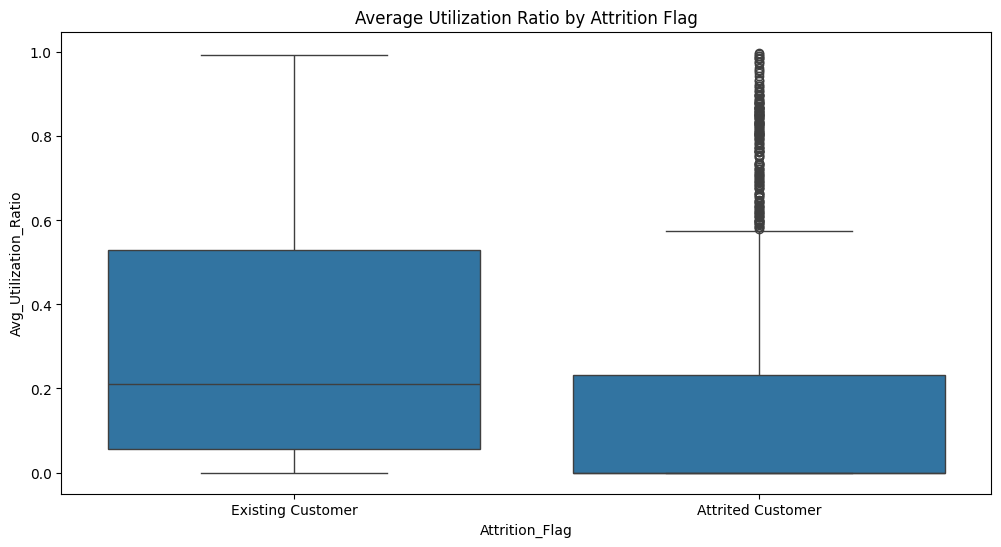

In [74]:
# Analyze Avg_Utilization_Ratio distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Avg_Utilization_Ratio', data=bank_data)
plt.title('Average Utilization Ratio by Attrition Flag')
plt.show()

#### Analyze Total_Trans_Amt distribution

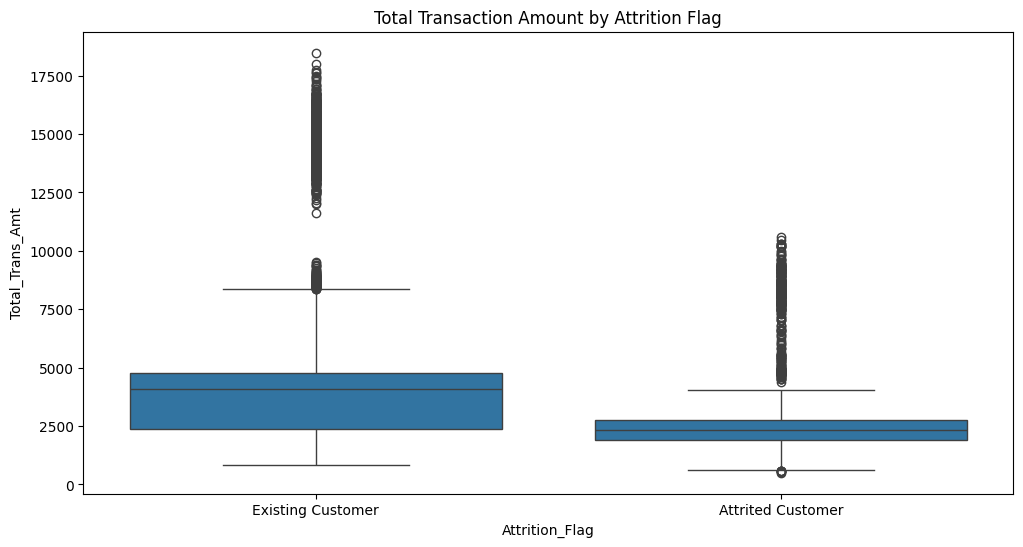

In [75]:
# Analyze Total_Trans_Amt distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Total_Trans_Amt', data=bank_data)
plt.title('Total Transaction Amount by Attrition Flag')
plt.show()

#### Analyze Total_Trans_Ct distribution

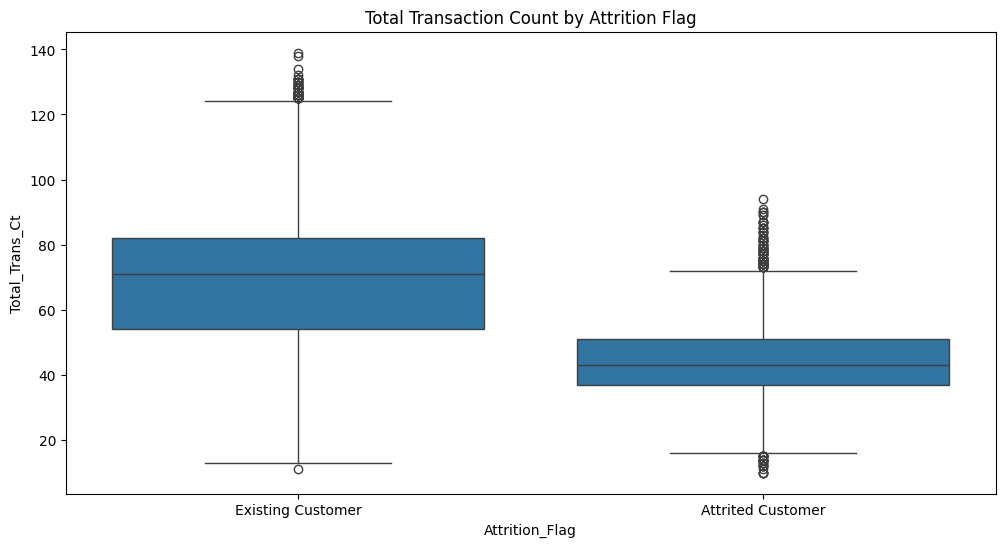

In [76]:
# Analyze Total_Trans_Ct distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Total_Trans_Ct', data=bank_data)
plt.title('Total Transaction Count by Attrition Flag')
plt.show()

### 3.3 Account Activity
- Compare `Months_on_book`, `Total_Relationship_Count`, and `Months_Inactive_12_mon`.
- Analyze `Contacts_Count_12_mon` to understand engagement levels.

#### Compare Months_on_book by Attrition Flag

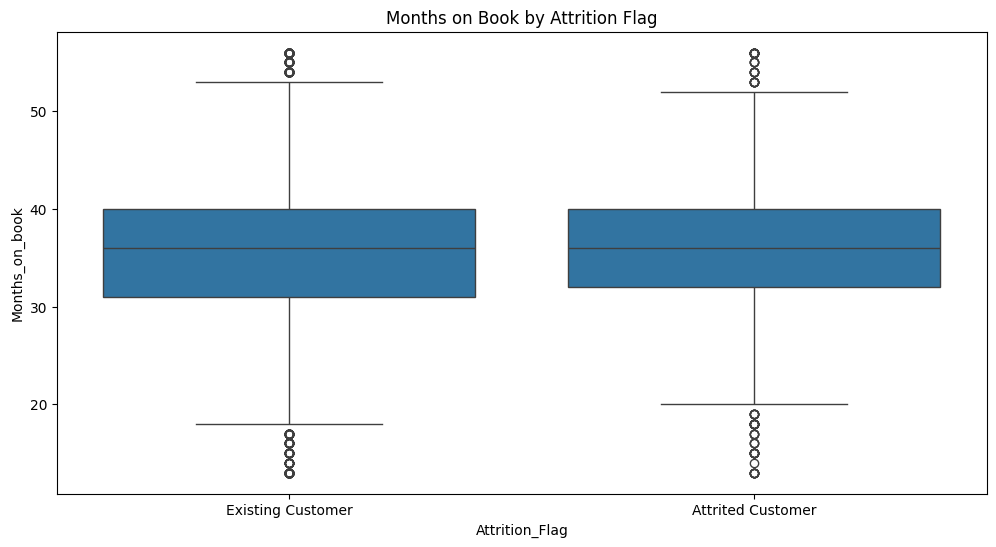

In [77]:
# Compare Months_on_book by Attrition Flag
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Months_on_book', data=bank_data)
plt.title('Months on Book by Attrition Flag')
plt.show()

#### Compare Total_Relationship_Count by Attrition Flag

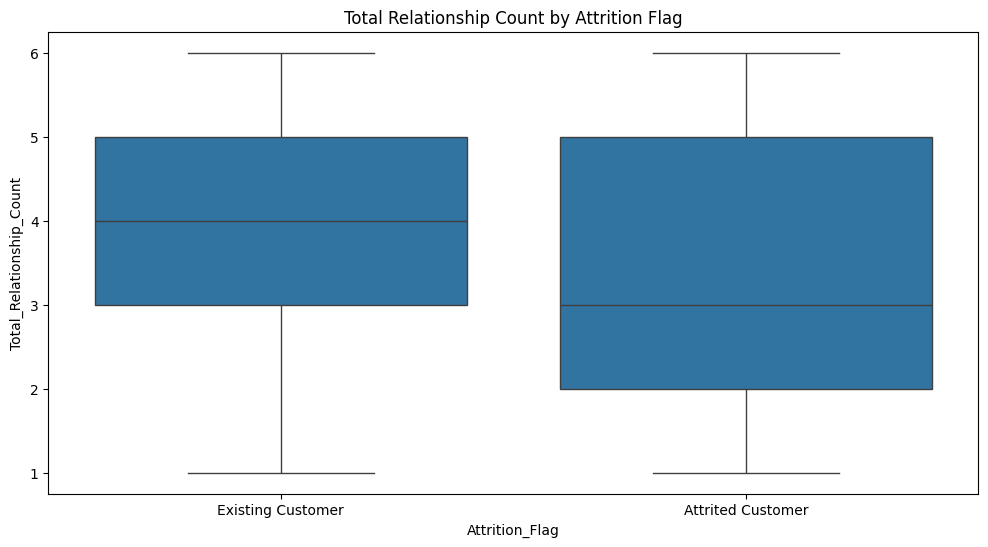

In [78]:
# Compare Total_Relationship_Count by Attrition Flag
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Total_Relationship_Count', data=bank_data)
plt.title('Total Relationship Count by Attrition Flag')
plt.show()

#### Compare Months_Inactive_12_mon by Attrition Flag

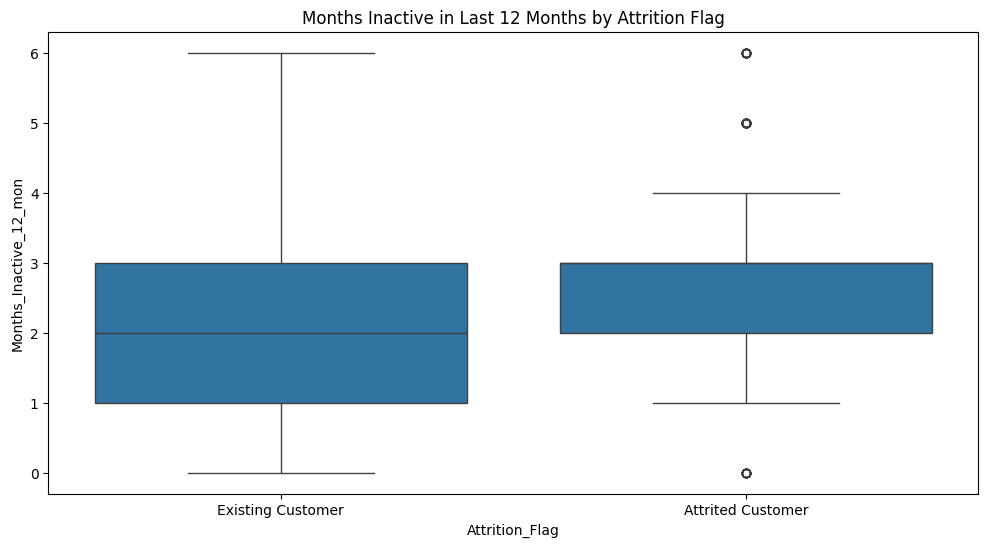

In [79]:
# Compare Months_Inactive_12_mon by Attrition Flag
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Months_Inactive_12_mon', data=bank_data)
plt.title('Months Inactive in Last 12 Months by Attrition Flag')
plt.show()

####  Analyze Contacts_Count_12_mon by Attrition Flag

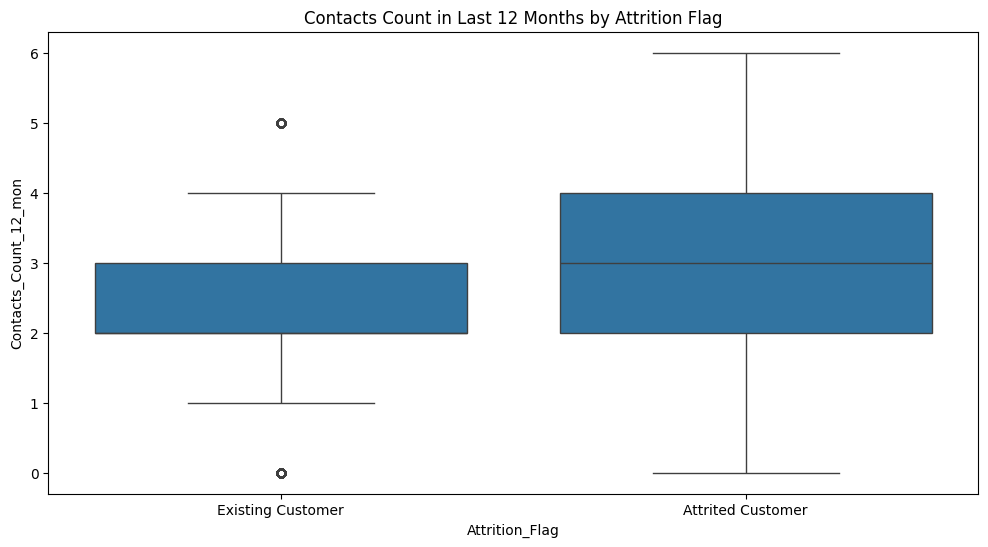

In [80]:
# Analyze Contacts_Count_12_mon by Attrition Flag
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Contacts_Count_12_mon', data=bank_data)
plt.title('Contacts Count in Last 12 Months by Attrition Flag')
plt.show()

## 4. Feature Engineering
- Create new features such as:
    - `Credit_Utilization` = `Total_Revolving_Bal` / `Credit_Limit`
    - `Engagement_Score` = `Total_Trans_Ct` / `Months_on_book`
- Group categorical variables into meaningful bins (e.g., `Income_Category`, `Credit_Limit_Group`).

In [81]:
# Create new features
bank_data['Credit_Utilization'] = bank_data['Total_Revolving_Bal'] / bank_data['Credit_Limit']
bank_data['Engagement_Score'] = bank_data['Total_Trans_Ct'] / bank_data['Months_on_book']

# Group Credit_Limit into bins
credit_limit_bins = [0, 5000, 10000, 20000, 50000, 100000]
credit_limit_labels = ['0-5k', '5k-10k', '10k-20k', '20k-50k', '50k-100k']
bank_data['Credit_Limit_Group'] = pd.cut(bank_data['Credit_Limit'], bins=credit_limit_bins, labels=credit_limit_labels, right=False)

# Display the first few rows to verify the new features
print(bank_data[['Credit_Utilization', 'Engagement_Score', 'Credit_Limit_Group']].head())

   Credit_Utilization  Engagement_Score Credit_Limit_Group
0            0.284639          0.904762               0-5k
1                 0.0          0.785714               0-5k
2            0.280727              1.38               0-5k
3            0.474171              1.75               0-5k
4            0.068827              3.12            10k-20k


## 5. Statistical Analysis
- Perform hypothesis testing (e.g., t-tests, chi-square tests) to identify significant differences between attritted and existing customers.
- Correlation analysis to find relationships between features and attrition.

T-tests for Numerical Features:
Age: t-statistic = 1.90, p-value = 0.0577
Dependent_count: t-statistic = 1.94, p-value = 0.0525
Credit_Limit: t-statistic = -2.40, p-value = 0.0164
Total_Trans_Amt: t-statistic = -22.69, p-value = 0.0000
Total_Trans_Ct: t-statistic = -54.14, p-value = 0.0000
Avg_Utilization_Ratio: t-statistic = -18.62, p-value = 0.0000
Credit_Utilization: t-statistic = -18.62, p-value = 0.0000
Engagement_Score: t-statistic = -38.91, p-value = 0.0000

Chi-Square Tests for Categorical Features:
Gender: chi2 = 13.87, p-value = 0.0002
Education_Level: chi2 = 12.51, p-value = 0.0515
Marital_Status: chi2 = 6.06, p-value = 0.1089
Income_Category: chi2 = 12.83, p-value = 0.0250
Credit_Limit_Group: chi2 = 12.71, p-value = 0.0053


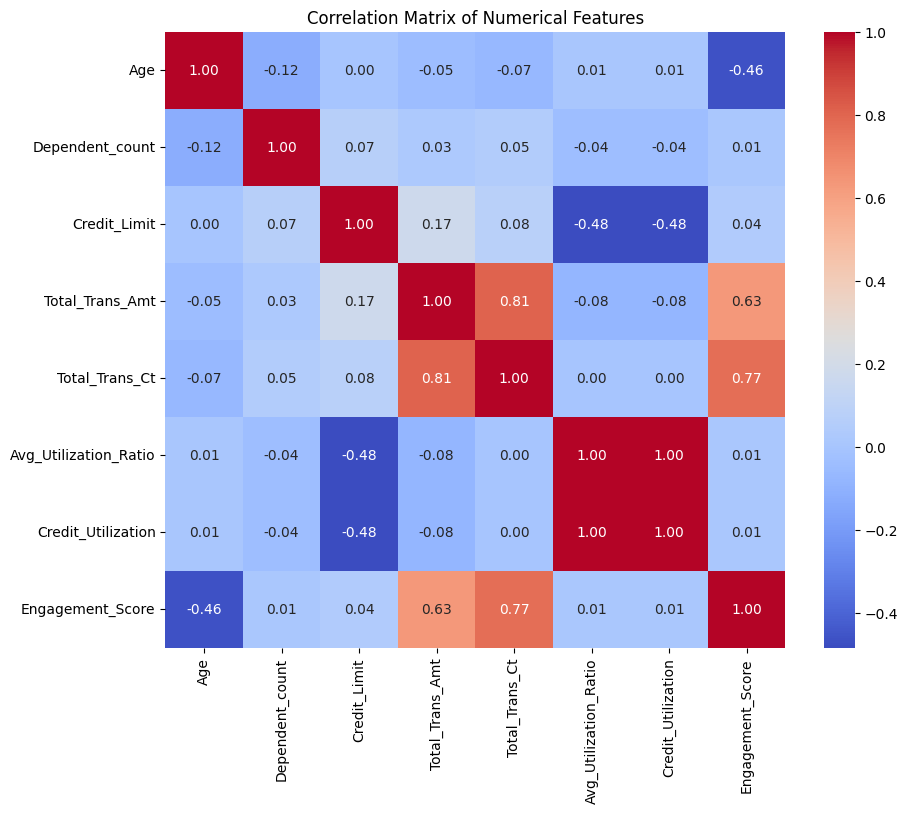

In [84]:
# Hypothesis Testing: t-tests for numerical features
# Ensure the required columns 'Credit_Utilization', 'Engagement_Score', and 'Credit_Limit_Group' exist in the DataFrame
required_columns = ['Credit_Utilization', 'Engagement_Score', 'Credit_Limit_Group']
missing_columns = [col for col in required_columns if col not in bank_data.columns]

# Create missing columns if necessary
if 'Credit_Utilization' in missing_columns:
    bank_data['Credit_Utilization'] = bank_data['Total_Revolving_Bal'] / bank_data['Credit_Limit']
if 'Engagement_Score' in missing_columns:
    bank_data['Engagement_Score'] = bank_data['Total_Trans_Ct'] / bank_data['Months_on_book']
if 'Credit_Limit_Group' in missing_columns:
    credit_limit_bins = [0, 5000, 10000, 20000, 50000, 100000]
    credit_limit_labels = ['0-5k', '5k-10k', '10k-20k', '20k-50k', '50k-100k']
    bank_data['Credit_Limit_Group'] = pd.cut(bank_data['Credit_Limit'], bins=credit_limit_bins, labels=credit_limit_labels, right=False)

# Update attrited and non_attrited DataFrames after creating missing columns
attrited = bank_data[bank_data['Attrition_Flag'] == 'Attrited Customer']
non_attrited = bank_data[bank_data['Attrition_Flag'] == 'Existing Customer']

numerical_features = ['Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio', 'Credit_Utilization', 'Engagement_Score']

print("T-tests for Numerical Features:")
for feature in numerical_features:
    t_stat, p_val = ttest_ind(attrited[feature], non_attrited[feature], equal_var=False)
    print(f"{feature}: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")

# Hypothesis Testing: chi-square tests for categorical features
categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Credit_Limit_Group']

print("\nChi-Square Tests for Categorical Features:")
for feature in categorical_features:
    contingency_table = pd.crosstab(bank_data[feature], bank_data['Attrition_Flag'])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"{feature}: chi2 = {chi2:.2f}, p-value = {p_val:.4f}")

# Correlation Analysis
correlation_matrix = bank_data[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 6. Predictive Modeling
- Build a classification model to predict attrition:
    - Split data into training and testing sets.
    - Use models like Logistic Regression, Random Forest, or Gradient Boosting.
    - Evaluate model performance using metrics like accuracy, precision, recall, and F1-score.

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define features and target variable
features = ['Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio', 
            'Credit_Utilization', 'Engagement_Score']
X = bank_data[features]
y = bank_data['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.93
Precision: 0.83
Recall: 0.73
F1-Score: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2551
           1       0.83      0.73      0.78       488

    accuracy                           0.93      3039
   macro avg       0.89      0.85      0.87      3039
weighted avg       0.93      0.93      0.93      3039



## 7. Insights and Recommendations
- Summarize key findings from the analysis.
- Provide actionable recommendations to reduce attrition, such as:
    - Targeted engagement strategies for high-risk customers.
    - Incentives for customers with low transaction activity.
    - Personalized offers based on financial behavior.

## 7. Insights and Recommendations

### Key Findings:
1. **Demographic Insights**:
    - Attrited customers are more prevalent in certain age groups, particularly in the 36-45 and 46-55 age ranges.
    - Gender distribution shows a slight imbalance, with more attrition observed among females.

2. **Financial Behavior**:
    - Attrited customers tend to have lower credit limits and higher average utilization ratios.
    - Spending behavior analysis reveals that attrited customers have lower total transaction amounts and counts.

3. **Account Activity**:
    - Attrited customers show lower engagement scores and fewer total relationships with the bank.
    - They also have higher inactivity periods and contact counts in the last 12 months, indicating potential dissatisfaction or disengagement.

4. **Statistical Analysis**:
    - Significant differences were observed in key features like `Credit_Limit`, `Avg_Utilization_Ratio`, and `Total_Trans_Amt` between attrited and existing customers.
    - Categorical features like `Income_Category` and `Education_Level` also show notable differences.

### Recommendations:
1. **Targeted Engagement Strategies**:
    - Focus on customers with high inactivity periods and low engagement scores.
    - Implement personalized communication to re-engage these customers.

2. **Incentives for Low Transaction Activity**:
    - Offer rewards or cashback programs to customers with low transaction amounts or counts.
    - Introduce tiered benefits to encourage higher spending and transactions.

3. **Personalized Offers**:
    - Use financial behavior data to create tailored offers, such as credit limit increases for customers with low utilization ratios.
    - Provide educational resources or financial planning tools for customers in lower income categories.

4. **Proactive Retention Measures**:
    - Monitor early warning signs like increased inactivity or higher contact counts.
    - Develop a predictive model to identify high-risk customers and intervene with retention strategies.

5. **Enhanced Customer Relationships**:
    - Strengthen relationships by offering exclusive benefits to long-term customers.
    - Conduct regular surveys to gather feedback and address customer concerns proactively.

## 8. Visualization
- Use visualizations to support findings:
    - Bar charts for categorical comparisons.
    - Box plots for numerical distributions.
    - Heatmaps for correlation analysis.

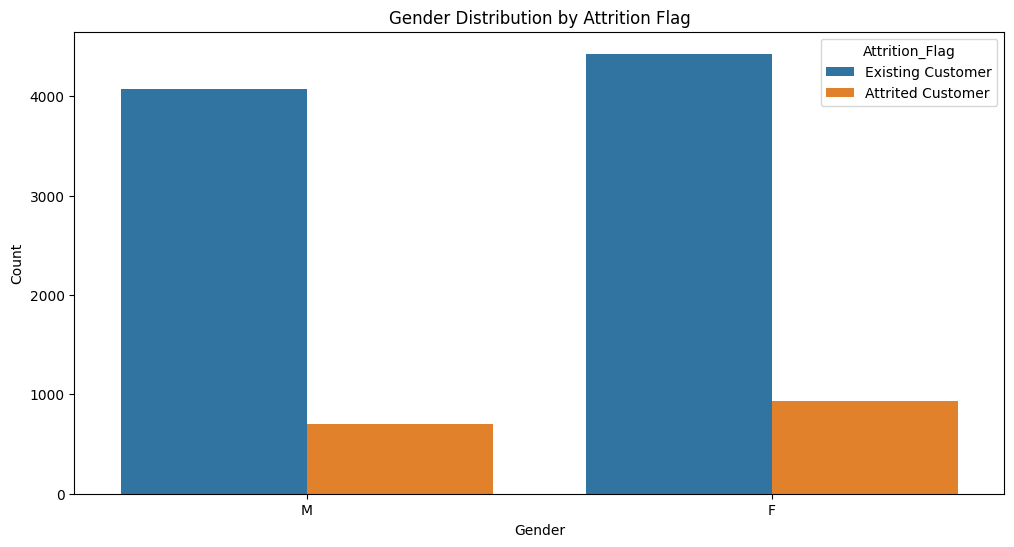

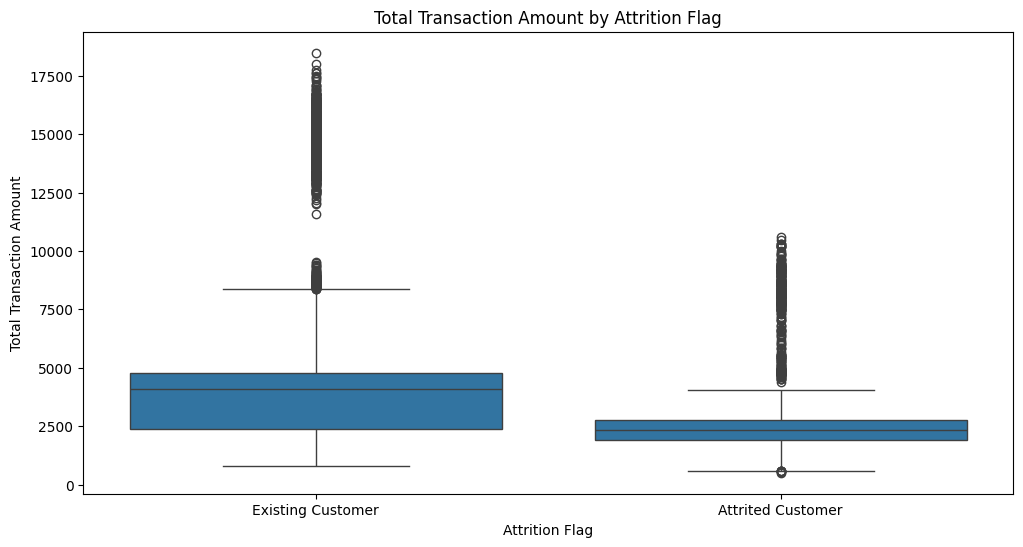

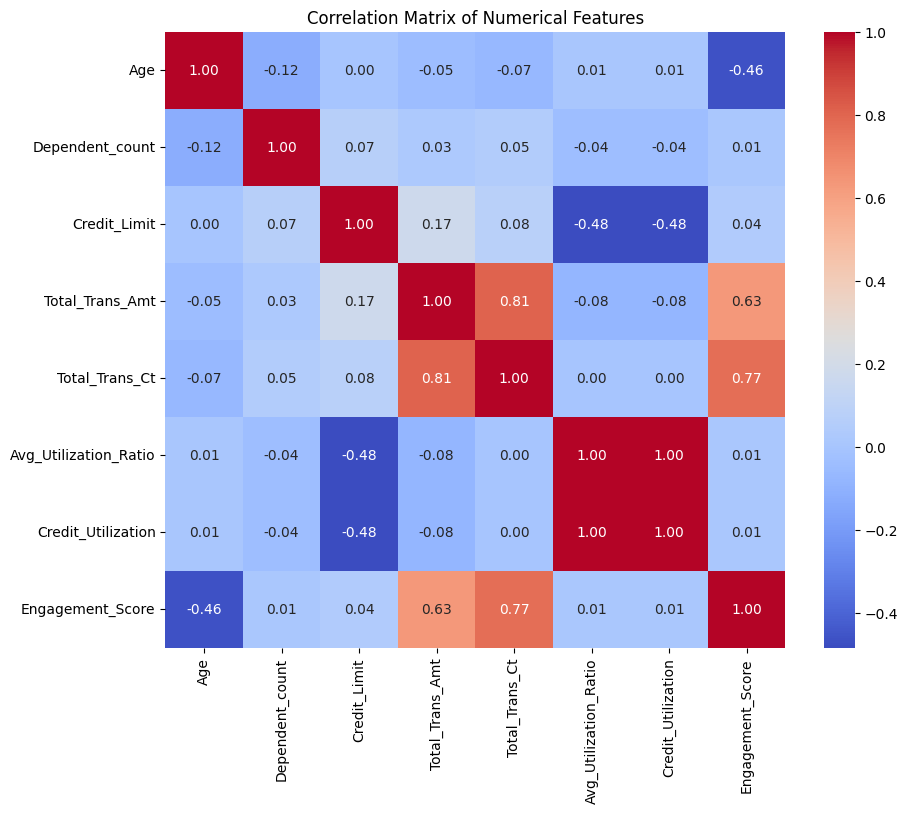

In [87]:
# Bar chart for categorical comparisons: Gender distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Gender', hue='Attrition_Flag', data=bank_data)
plt.title('Gender Distribution by Attrition Flag')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Box plot for numerical distributions: Total Transaction Amount
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition_Flag', y='Total_Trans_Amt', data=bank_data)
plt.title('Total Transaction Amount by Attrition Flag')
plt.xlabel('Attrition Flag')
plt.ylabel('Total Transaction Amount')
plt.show()

# Heatmap for correlation analysis
numerical_features = ['Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 
                      'Avg_Utilization_Ratio', 'Credit_Utilization', 'Engagement_Score']
correlation_matrix = bank_data[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 9. Conclusion
- Recap the main drivers of attrition.
- Highlight next steps for further analysis or business actions.

## 9. Conclusion

### Main Drivers of Attrition:
1. **Demographic Factors**:
    - Certain age groups, particularly 36-45 and 46-55, show higher attrition rates.
    - Gender imbalance with slightly higher attrition among females.

2. **Financial Behavior**:
    - Attrited customers have lower credit limits and higher average utilization ratios.
    - Spending behavior indicates lower transaction amounts and counts among attrited customers.

3. **Account Activity**:
    - Attrited customers exhibit lower engagement scores and fewer total relationships with the bank.
    - Higher inactivity periods and contact counts suggest disengagement or dissatisfaction.

4. **Statistical Insights**:
    - Significant differences in features like `Credit_Limit`, `Avg_Utilization_Ratio`, and `Total_Trans_Amt`.
    - Categorical variables such as `Income_Category` and `Education_Level` also play a role.

### Next Steps:
1. **Further Analysis**:
    - Investigate additional features or external factors influencing attrition.
    - Perform segmentation analysis to identify distinct customer groups.

2. **Model Refinement**:
    - Enhance the predictive model by incorporating additional features or advanced algorithms.
    - Conduct feature importance analysis to prioritize key drivers.

3. **Business Actions**:
    - Develop targeted retention strategies for high-risk customers.
    - Implement personalized offers and incentives to improve customer satisfaction and engagement.

4. **Monitoring and Feedback**:
    - Establish a system to monitor early warning signs of attrition.
    - Gather customer feedback regularly to address concerns and improve services.